# Examples for final report

## Imports

In [22]:
from contextlib import suppress
from itertools import product
from functools import partial, reduce
import pathlib
import numpy as np
import pandas as pd
import recordlinkage as rl

from scipy.optimize import bisect
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from adjacent_block_index import AdjacentBlockIndex

%matplotlib inline
sns.set_style('white')

## Settings

In [13]:
tradeoff_stats_file = pathlib.Path('../data/cache/experiments/tradeoff_stats_generated.pickle')
tradeoff_stats_file.parent.mkdir(parents=True, exist_ok=True)

## Example points

In [14]:
def sample_dataset_and_true_matches(n_base=500, n_perturbations=1, n_columns=5, null_proportion=0.01):
    np.random.seed(1)
    axis_names = ['dim_{}'.format(n) for n in range(1, n_columns+1)]
    def random_ordinates(random_func, scale=1):
        return pd.DataFrame(data=random_func(n_base, n_columns)*scale, columns=axis_names)
    base_points = random_ordinates(np.random.rand, 1)
    points = pd.concat([base_points] + [base_points + random_ordinates(np.random.randn, 0.01) for _ in range(n_perturbations)]
                       , ignore_index=True)
    points.index = ['point_{n}'.format(**locals()) for n in range(len(points))]
    true_matches = pd.MultiIndex.from_arrays(arrays=points.index.values.reshape(n_perturbations + 1,-1), names=['p1', 'p2'])
    def with_random_nulls(df, null_proportion, inplace=False):
        rows, cols = [a.flatten() for a in np.meshgrid(np.arange(len(df)), np.arange(len(df.columns)))]
        ndx_nulls = np.random.choice(np.arange(len(rows)), size=int(null_proportion*len(rows)), replace=False)
        result = df if inplace else df.copy()
        result.values[rows[ndx_nulls], cols[ndx_nulls]] = np.nan
        return result
    points = with_random_nulls(points, null_proportion=null_proportion, inplace=True)
    return points, true_matches
points, true_matches = sample_dataset_and_true_matches()

In [15]:
stats = pd.DataFrame()
indices = {}
full_index_size = rl.max_pairs(points)
stats.index.name = 'index_method'
def index_performance_stats(ndx):
    def normalized_index(ndx):
        ascending = ndx.get_level_values(0) < ndx.get_level_values(1)
        return ndx[ascending] | ndx.reorder_levels([1,0])[~ascending]
    norm_ndx = normalized_index(ndx)
    norm_true = normalized_index(true_matches)
    norm_common = norm_ndx & norm_true
    return {'recall': len(norm_common) / len(norm_true),
            'specificity': len(norm_common) / (len(norm_ndx) or 1),
            'reduction_ratio': 1 - (len(norm_ndx) / full_index_size)}
def record_index(label, index, index_type=None, axes=None):
    indices[label] = index
    stats.loc[label, 'pair_count'] = len(index)
    stats.loc[label, 'index_type'] = index_type or ''
    stats.loc[label, 'axes'] = str(axes or '')
    for k, v in sorted(index_performance_stats(index).items()):
        stats.loc[label, k] = v
all_pairs_label = 'All pairs'
record_index('True matches', true_matches, 'true')
record_index(all_pairs_label, rl.FullIndex().index(points), rl.FullIndex.__name__)

In [16]:
def plot_points(row_width=None, col_width=None, ax=None):
    if ax is None: ax = plt.gca()
    for col_name, lim_fun, div_width, line_fun in zip(points.columns, [ax.set_xlim, ax.set_ylim], [col_width, row_width], [ax.axvline, ax.axhline]):
        col = points[col_name]
        lo, hi = col.min(), col.max()
        lim_fun(lo, hi)
        if div_width:
            ordinates = np.arange(lo, hi, div_width)
            if len(ordinates) < 50:
                for ordinate in ordinates:
                    line_fun(ordinate, color='grey')
    if row_width or col_width:
        def block_status(axis_name, width):
            return np.floor((points[axis_name] - points[axis_name].min())/width) % 2 if (width>0) else 0
        highlighted = block_status(points.columns[0], col_width) == block_status(points.columns[1], row_width)
        sections = [points.loc[ndx, :] for ndx in [highlighted, ~highlighted]]
    else:
        sections = [points]
    for section in sections:
        sns.regplot(*list(points.columns)[:2], data=section, fit_reg=False, marker='.', ax=ax)

### Distance frequencies

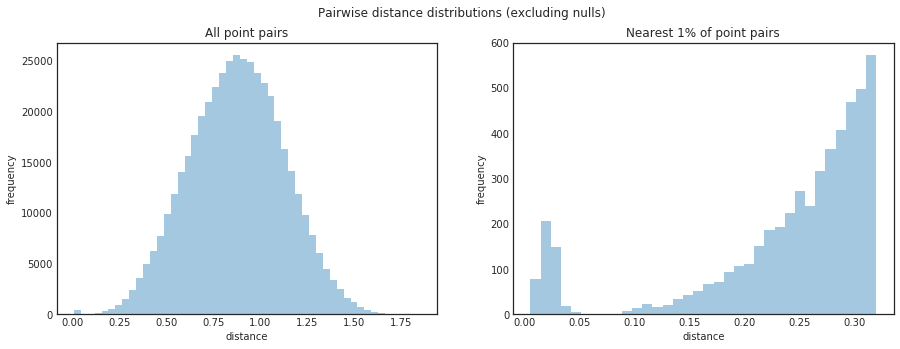

In [17]:
def distances_from_index(index):
    ordinates = points
    index_values = index.to_frame().values
    diffs = ordinates.loc[index_values[:,0],:].values - ordinates.loc[index_values[:,1],:].values
    return np.sqrt(np.sum(diffs * diffs, axis=1))
to_plot = distances_from_index(indices[all_pairs_label])
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
detail_proportion = 0.01
for (title, dists), ax in zip([('All point pairs', to_plot), ('Nearest {:.0%} of point pairs'.format(detail_proportion), np.sort(to_plot)[:1+int(detail_proportion * len(to_plot))])], axs.flatten()):
    sns.distplot(dists[~np.isnan(dists)], ax=ax, kde=False)
    ax.set_title(title); ax.set_xlabel('distance'), ax.set_ylabel('frequency')
plt.suptitle('Pairwise distance distributions (excluding nulls)')
plt.show();

## Blocking comparison

In [18]:
def solved_index_param(index_getter, target_recall, x_min, x_max):
    def recall_error(x):
        return target_recall - index_performance_stats(index_getter(x))['recall']
    return bisect(recall_error, x_min, x_max)

In [19]:
#from itertools import product
#from recordlinkage.indexing import BlockIndex

#def ranking1d(x):
#    ndx_by_rank = np.argsort(x)
#    rank_by_ndx = np.empty_like(ndx_by_rank)
#    rank_by_ndx[ndx_by_rank] = np.arange(len(ndx_by_rank))
#    return rank_by_ndx

#class AdjacentBlockIndex(BlockIndex):
#    '''
#    :class:`recordlinkage.indexing.BlockIndex` that 
#    includes matches with elements in adjacent blocks
#    and null values
#    '''
#    def __init__(self, *args, max_nulls=0, **kwargs):
#        super().__init__(*args, **kwargs)
#        self.max_nulls = max_nulls
#    def _link_index(self, df_a, df_b):
#        default_on = list(set(df_a.columns) & set(df_b.columns))
#        raw_key_columns = [side_on or self.on or default_on for side_on in [self.left_on, self.right_on]]
#        if not (all(raw_key_columns) and (len(raw_key_columns[0]) == len(raw_key_columns[1]))):
#            raise IndexError('Invalid indexing columns')
#        key_dfs = [df[side_on].copy() for df, side_on in zip([df_a, df_b], raw_key_columns)]
#        key_columns = ['k_{ndx}'.format(**locals()) for ndx in range(len(key_dfs[0].columns))]
#        for df in key_dfs:
#            df.columns = key_columns
#        def get_key_rank(key_series):
#            unique_values = key_series.unique()
#            result = pd.Series(ranking1d(unique_values), index=unique_values)
#            if np.nan in result:
#                result[np.nan] = np.nan
#            return result
#        key_ranks = {name: get_key_rank(vals) 
#                     for name, vals in pd.concat(key_dfs, ignore_index=True).iteritems()}
#        index_columns = ['index_{ndx}'.format(**locals()) for ndx in range(len(key_dfs))]
#        for index_column, key_df in zip(index_columns, key_dfs):
#            key_df[index_column] = key_df.index
#            for col in key_columns:
#                key_df[col] = key_ranks[col][key_df[col].values].values
#        def get_block_df(key_df, df_id):
#            blocks = key_df[key_columns].drop_duplicates().reset_index(drop=True)
#            blocks.index.name = 'block_id_{df_id}'.format(**locals())
#            return blocks
#        block_dfs = [get_block_df(key_df, df_id) for df_id, key_df in enumerate(key_dfs)]
#        key_dfs = [key_df.join(block_df[key_columns].reset_index().set_index(key_columns), on=key_columns)
#                   for key_df, block_df in zip(key_dfs, block_dfs)]
#        def df_with_adjusted_nulls(df):
#            df = df[df[key_columns].isnull().sum(axis='columns') <= self.max_nulls]
#            for col in key_columns:
#                df[col].fillna(-2, inplace=True)            
#            return df
#        def get_adjusted_block_df(block_df_to_adjust, non_null_adjustments):
#            rank_increments = [non_null_adjustments+[np.nan] if (self.max_nulls > 0) and (np.nan in key_ranks[col]) else non_null_adjustments
#                               for col in key_columns]
#            rank_increment_combinations = np.array([incs.flatten() for incs in np.meshgrid(*rank_increments)])
#            rank_increment_combinations = rank_increment_combinations[:,(np.sum(np.isnan(rank_increment_combinations), axis=0)<=self.max_nulls)]
#            ix_repeated_rows = np.tile(np.arange(len(block_df_to_adjust)), rank_increment_combinations.shape[1])
#            result = pd.DataFrame((block_df_to_adjust[key_columns].values[...,np.newaxis] 
#                                   + rank_increment_combinations[np.newaxis,...]).transpose([2,0,1]).reshape(-1,len(key_columns)),
#                                  columns=key_columns,
#                                  index = block_df_to_adjust.index[ix_repeated_rows])
#            result = result.join(block_df_to_adjust[[c for c in block_df_to_adjust.columns if c not in result.columns]])
#            result = result.reset_index().drop_duplicates().set_index(block_df_to_adjust.index.name)
#            result = df_with_adjusted_nulls(result)
#            return result
#        ext_block_dfs = [get_adjusted_block_df(df, non_null_adjustments=[-1,0,1])
#                         for df, adjs in zip(block_dfs, [[-1,0,1], [0]])]
#        adj_block_dfs = [df_with_adjusted_nulls(df) for df in block_dfs]
#        block_match_components = [df0.reset_index().join(df1.reset_index().set_index(key_columns), on=key_columns, how='inner')
#                                  for df0, df1 in zip(ext_block_dfs, reversed(adj_block_dfs))]
#        block_matches = pd.concat(block_match_components, ignore_index=True)
#        block_matches = block_matches.loc[(block_matches[key_columns]<0).sum(axis='columns').values<=self.max_nulls, :]
#        block_id_columns = [df.index.name for df in block_dfs]
#        block_matches = block_matches[block_id_columns].drop_duplicates()
#        record_index_dfs = [df[[c for c in df.columns if c in index_columns or c in block_id_columns]]
#                            for df in key_dfs]
#        record_matches = record_index_dfs[0]\
#                         .merge(block_matches, on=block_id_columns[0])\
#                         .merge(record_index_dfs[1], on=block_id_columns[1])
#        record_matches = record_matches[index_columns].drop_duplicates()
#        record_matches = record_matches[record_matches.iloc[:,0] != record_matches.iloc[:,1]]
#        return record_matches.set_index(index_columns).index.rename([df.index.name for df in key_dfs])


In [20]:
'''
def block_index(index_type, axis_names, block_size, **kwargs):
    blocks = pd.DataFrame({axis_name: np.floor((points[axis_name] - points[axis_name].min()) / block_size)
                          for axis_name in axis_names})
    return index_type(on=list(blocks.columns), **kwargs).index(blocks)

def get_block_size(index_type, axis_names, target_recall, max_blocks=1000):
    max_size = points.max().max() - points.min().min()
    return solved_index_param(index_getter=partial(block_index, index_type, axis_names), target_recall=target_recall, x_min=max_size/max_blocks, x_max=max_size)

axis_names_2d = axis_names[:2]
target_recall = 0.9
index_types = [BlockIndex, AdjacentBlockIndex]
fig, axs = plt.subplots(figsize=(15,5*len(index_types)), nrows=len(index_types), ncols=len(axis_names_2d)+1)
for (index_type, current_axis_names), ax in zip(product(index_types, [[nm] for nm in axis_names_2d] + [axis_names_2d]), axs.flatten()):
    ax.set_color_cycle(None)
    block_size = get_block_size(index_type=index_type, axis_names=current_axis_names, target_recall=target_recall)
    label = '{index_type.__name__}({current_axis_names}, {block_size:.2f})'.format(**locals())
    record_index(label, block_index(index_type=index_type, axis_names=current_axis_names, block_size=block_size), 
                 index_type.__name__, current_axis_names)
    plot_points(*list(reversed(list((block_size if nm in current_axis_names else 0) for nm in axis_names_2d))), ax=ax)
    ax.set_title(label)
plt.suptitle('Blocking comparison (target recall = {target_recall})'.format(**locals()))
plt.show();
''';

## Alternative

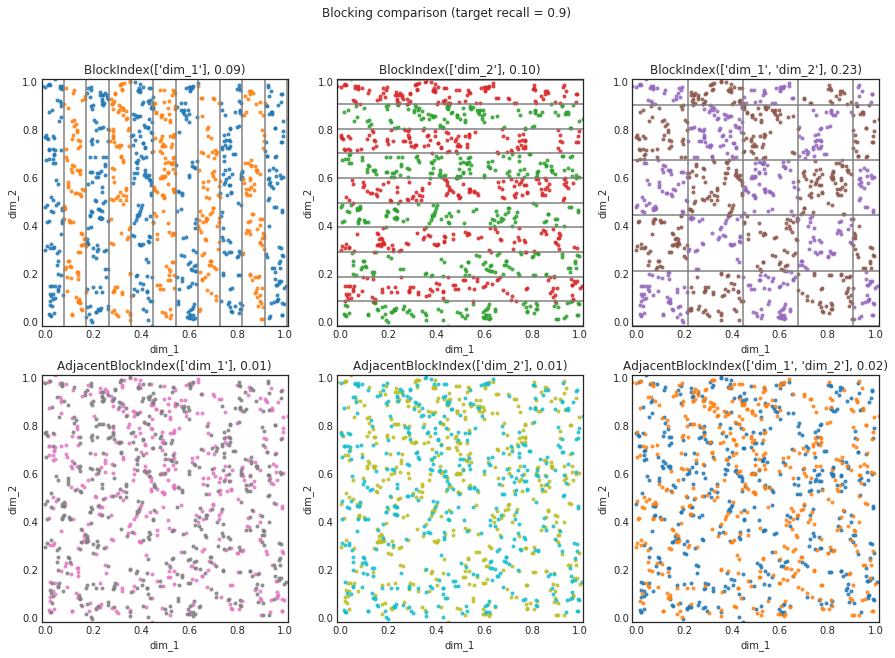

In [23]:
def block_index(index_type, axis_names, block_size, **kwargs):
    blocks = pd.DataFrame({axis_name: np.floor((points[axis_name] - points[axis_name].min()) / block_size)
                          for axis_name in axis_names})
    return index_type(on=list(blocks.columns), **kwargs).index(blocks)

def get_block_size(index_type, axis_names, target_recall, max_blocks=1000):
    max_size = points.max().max() - points.min().min()
    return solved_index_param(index_getter=partial(block_index, index_type, axis_names), target_recall=target_recall, x_min=max_size/max_blocks, x_max=max_size)

axis_names_2d = list(points.columns)[:2]
target_recall = 0.9
index_types = [rl.BlockIndex, AdjacentBlockIndex]
fig, axs = plt.subplots(figsize=(15,5*len(index_types)), nrows=len(index_types), ncols=len(axis_names_2d)+1)
for (index_type, current_axis_names), ax in zip(product(index_types, [[nm] for nm in axis_names_2d] + [axis_names_2d]), axs.flatten()):
    ax.set_color_cycle(None)
    block_size = get_block_size(index_type=index_type, axis_names=current_axis_names, target_recall=target_recall)
    label = '{index_type.__name__}({current_axis_names}, {block_size:.2f})'.format(**locals())
    record_index(label, block_index(index_type=index_type, axis_names=current_axis_names, block_size=block_size), 
                 index_type.__name__, current_axis_names)
    plot_points(*list(reversed(list((block_size if nm in current_axis_names else 0) for nm in axis_names_2d))), ax=ax)
    ax.set_title(label)
plt.suptitle('Blocking comparison (target recall = {target_recall})'.format(**locals()))
plt.show();

## Sorted neighbourhood

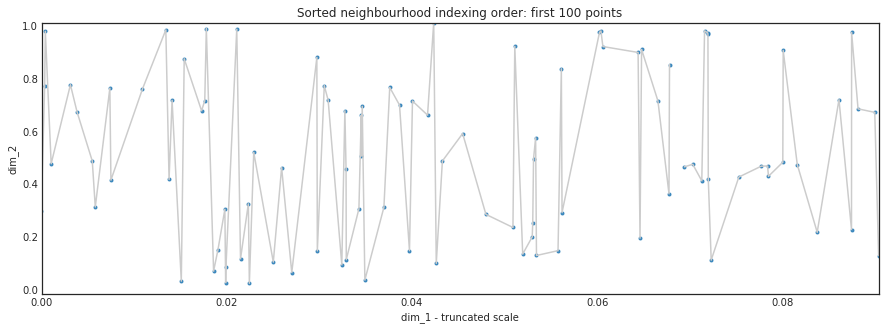

In [24]:
def smallest_integer_param(index_getter, min_recall, initial_guess=1, min_value=0, upward_sloping=True):
    bounds = [min_value, None]
    current_guess = initial_guess
    while (bounds[1] is None) or (bounds[1]-bounds[0] > 1):
        bounds[((index_performance_stats(index_getter(current_guess))['recall'] > min_recall) == upward_sloping) * 1] = current_guess
        current_guess = bounds[0] * 2 if bounds[1] is None else sum(bounds) // 2
    return bounds[upward_sloping * 1]

def sorted_neighbourhood_index(axis_name, window):
    return rl.SortedNeighbourhoodIndex(on=axis_name, window=window).index(points)

def get_sorted_neighbourhood_window(axis_name, min_recall=0.95, initial_guess=5):
    def window(half_window):
        return 1 + 2 * half_window
    half_window = smallest_integer_param(index_getter = (lambda half_window: sorted_neighbourhood_index(axis_name=axis_name, window=window(half_window))),
                                         min_recall = min_recall, initial_guess = max([1, initial_guess // 2]),
                                         upward_sloping=True)
    return window(half_window)

axis_name = points.columns[0]
window = get_sorted_neighbourhood_window(axis_name=axis_name, min_recall=target_recall)
record_index('SortedNeighbourhood({axis_name}, {window})'.format(**locals()), sorted_neighbourhood_index(axis_name, window), 
             rl.SortedNeighbourhoodIndex.__name__, [axis_name])
plt.figure(figsize=(15,5))
plot_points()
sorted_ordinates = points[points.columns[:2]].sort_values(axis_name).values
plt.plot(*sorted_ordinates.T, color='#cccccc')
n_points = 100
plt.gca().set_xlim(0, sorted_ordinates[n_points-1,0])
plt.title('Sorted neighbourhood indexing order: first {n_points} points'.format(**locals()))
plt.xlabel('{} - truncated scale'.format(axis_name))
plt.show();

## Statistics

In [25]:
pivoted_stats = stats.set_index(['index_type', 'axes']).unstack('axes')
pivoted_stats.style.format(lambda x: '' if pd.isnull(x) else (format(int(x), ',') if (x-int(x) == 0) else str(x)))

## Recall - reduction ratio tradeoff

In [26]:
from itertools import combinations, chain

def all_combinations(iterable, min_r=0, max_r=None):
    all_elems = list(iterable)
    return chain.from_iterable(combinations(all_elems, r) for r in range(max([int(min_r), 0]), min([len(all_elems), int(len(all_elems) if max_r is None else max_r)])+1))
def example_combinations(iterable, min_r=0, max_r=None):
    all_elems = list(iterable)
    return (all_elems[:r] for r in range(max([int(min_r), 0]), min([len(all_elems), int(len(all_elems) if max_r is None else max_r)])+1))

In [27]:
from operator import mul

def total_boundary_size(axis_discretization_intervals, points):
    axis_lengths = {col: (vals.max() - vals.min()) for col, vals in points.iteritems()}
    length_product = reduce(mul, axis_lengths.values(), 1)
    return sum(length_product / axis_lengths[axis] * int(axis_lengths[axis] / interval) 
               for axis, interval in axis_discretization_intervals.items()
               if interval)

In [28]:
import datetime
start_time = datetime.datetime.now()
exhaustive = False
combinations_to_use = all_combinations if exhaustive else example_combinations
tradeoff_stats = pd.DataFrame()
ordinate_range = points.max().max() - points.min().min()
for n_blocks in [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 300, 400, 500, 700, 1000]:
#for n_blocks in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    print(n_blocks, end=' ')
    block_size = ordinate_range / n_blocks
    for index_desc, cols in product([#rl.FullIndex,
                                     rl.SortedNeighbourhoodIndex, 
                                     rl.BlockIndex, 
                                     AdjacentBlockIndex, 
                                     (AdjacentBlockIndex, {'max_nulls': 1}), 
                                     (AdjacentBlockIndex, {'max_nulls': 2}),
                                    ], 
                                    combinations_to_use(points.columns, min_r=1)):
        index_type, index_kwargs = index_desc if isinstance(index_desc, tuple) else (index_desc, {})
        ndx_start_time = datetime.datetime.now()
        if index_type is rl.SortedNeighbourhoodIndex:
            if len(cols) > 1:
                continue
            param = 1 + 2*int(len(points) / n_blocks / 2)
            ndx = sorted_neighbourhood_index(axis_name=cols[0], window=param, **index_kwargs)
        elif index_type is rl.FullIndex:
            param = None
            ndx = index_type().index(points)
        else:
            param = block_size
            ndx = block_index(index_type=index_type, axis_names=cols, block_size=block_size, **index_kwargs)
        kwargs_repr = ', '.join([''] + ['{k}={v}'.format(**locals()) for k, v in sorted(index_kwargs.items())])
        label = '{index_type.__name__}({cols}, {param}{kwargs_repr})'.format(**locals())
        tradeoff_stats.loc[label, 'time'] = datetime.datetime.now() - ndx_start_time
        tradeoff_stats.loc[label, 'method'] = '{index_type.__name__} - {cols}{kwargs_repr}'.format(**locals())
        tradeoff_stats.loc[label, 'param'] = param
        tradeoff_stats.loc[label, 'n_pairs'] = len(ndx)
        tradeoff_stats.loc[label, 'dimensionality'] = len(cols)
        tradeoff_stats.loc[label, 'cls'] = index_type.__name__
        for k, v in index_kwargs.items():
            tradeoff_stats.loc[label, k] = v
        if index_type is rl.BlockIndex:
            tradeoff_stats.loc[label, 'total_boundary_size'] = total_boundary_size(axis_discretization_intervals={c: param for c in cols}, points=points)
        for k, v in index_performance_stats(ndx).items():
            tradeoff_stats.loc[label, k] = v
tradeoff_stats['dimensionality'] = tradeoff_stats['dimensionality'].astype(int)
print('elapsed: {}'.format(datetime.datetime.now() - start_time))

1 1.1 1.2 1.3 1.4 1.5 1.7 2 3 4 5 7 10 15 20 30 40 50 70 100 150 200 300 400 500 700 1000 elapsed: 0:09:57.176154


In [29]:
block_size = ordinate_range / 400
cols = points.columns
start_time = datetime.datetime.now()
ndx = block_index(index_type=AdjacentBlockIndex, axis_names=cols, block_size=block_size)
print(datetime.datetime.now() - start_time)

0:00:01.812358


In [30]:
tradeoff_stats.to_pickle(str(tradeoff_stats_file))

1


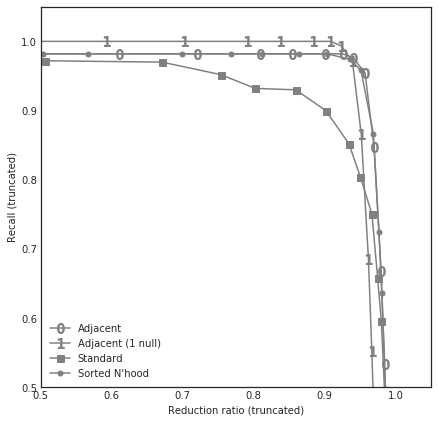

2


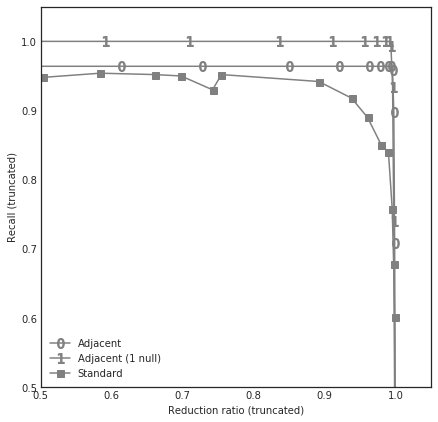

3


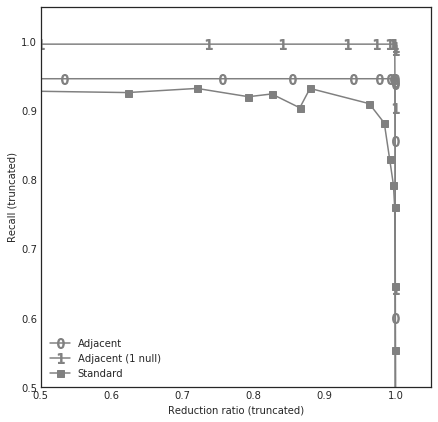

4


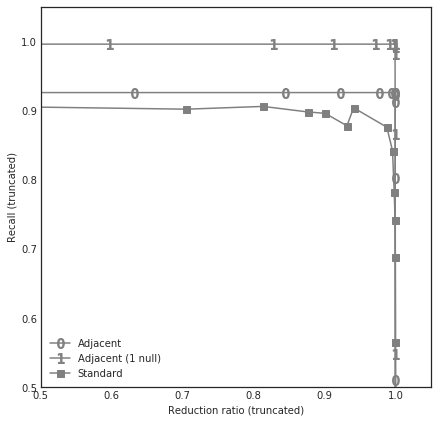

5


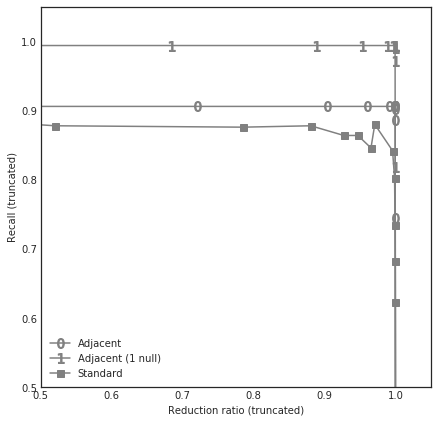

In [35]:
axis_vars = ['reduction_ratio', 'recall']
method_descriptions = {'BlockIndex': 'Standard',
                       'SortedNeighbourhoodIndex': 'Sorted N\'hood',
                       'AdjacentBlockIndex': 'Adjacent',
                      }
markers = {('BlockIndex', None): ('s', 7),
           ('SortedNeighbourhoodIndex', None): ('o', 5),
           ('AdjacentBlockIndex', None): ('$0$', 10),
           ('AdjacentBlockIndex', 1): ('$1$', 10),
           ('AdjacentBlockIndex', 2): ('$2$', 10),
           }

distinct_dimensionalities = sorted(tradeoff_stats['dimensionality'].unique())
for dimensionality, ax in zip(distinct_dimensionalities, axs.flatten()):
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    stats_for_dimensionality = tradeoff_stats[tradeoff_stats['dimensionality'] == dimensionality]
    for mth in np.sort(stats_for_dimensionality['method'].unique()):
        sorted_points = tradeoff_stats[tradeoff_stats['method'] == mth].sort_values('param')
        cls_name = sorted_points['cls'].iloc[0]
        description = method_descriptions[cls_name]
        max_nulls = sorted_points['max_nulls'].iloc[0]
        if max_nulls > 1:#dimensionality:
            continue
        max_nulls_repr = '' if pd.isnull(max_nulls) else ' ({} null{})'.format(int(max_nulls), '' if max_nulls == 1 else 's')
        label = '{description}{max_nulls_repr}'.format(**locals())
        marker, markersize = markers[(cls_name, None if pd.isnull(max_nulls) else int(max_nulls))]
        #linestyle='None'
        linestyle='-'
        ax.plot(*[sorted_points[col].values for col in axis_vars], color='grey', linestyle=linestyle, marker=marker, markersize=markersize, label=label)
    ax.legend(loc='lower left')
    ax.set_xlabel(axis_vars[0]); ax.set_ylabel(axis_vars[1])
    ax.set_ylim(0.5, 1.05)
    ax.set_xlim(0.5, 1.05)
    ax.set_xlabel('Reduction ratio (truncated)'); ax.set_ylabel('Recall (truncated)')
    #ax.set_title('{dimensionality} blocking key{s}'.format(s='' if dimensionality == 1 else 's', **locals()))
    print(dimensionality)
    plt.show()

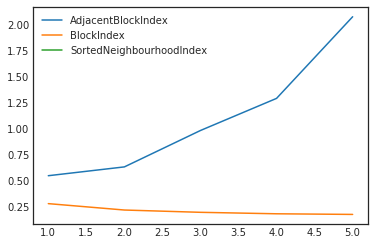

In [32]:
ts = tradeoff_stats.copy()
ts['seconds'] = ts['time'].dt.total_seconds()
itemization_keys = ['cls', 'dimensionality']
mean_times = ts.groupby(itemization_keys)['seconds'].mean().unstack('cls')
plt.figure()
ax = plt.gca()
for name, vals in mean_times.iteritems():
    ax.plot(vals.index.values, vals.values, label=name)
plt.legend()
plt.show();

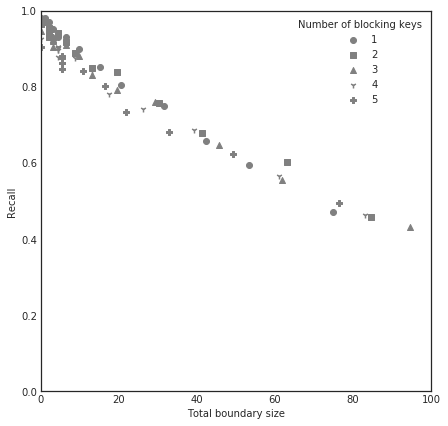

In [33]:
def plot_vs_total_boundary_size(stat_name, xlims=None, ylims=None):
    to_plot = tradeoff_stats[~tradeoff_stats['total_boundary_size'].isnull()]
    legend_title = 'Number of blocking keys'
    to_plot[legend_title] = to_plot['dimensionality']
    #sns.lmplot(x='total_boundary_size', y=stat_name, hue=legend_title, data=to_plot, fit_reg=False, size=5, legend_out=False)
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    marker_types = np.array(['o', 's', '^', '1', 'P', '*'])
    for ndx, (marker, dimensionality) in enumerate(zip(marker_types, to_plot['dimensionality'].unique())):
        rows = to_plot['dimensionality'] == dimensionality
        ax.scatter(to_plot['total_boundary_size'][rows], to_plot[stat_name][rows], marker=marker, color='grey', label=str(dimensionality))
    plt.legend(title='Number of blocking keys')
    for lims, meth in [(xlims, ax.set_xlim), (ylims, ax.set_ylim)]:
        if lims:
            meth(*lims)
    #ax.set_title('Standard Blocking: {stat_name} vs total boundary size'.format(**locals()))
    ax.set_xlabel('Total boundary size'), ax.set_ylabel(stat_name.title())
    plt.show()
max_boundary_size = 100
plot_vs_total_boundary_size('recall', xlims=(0, max_boundary_size), ylims=(0, 1))

## OLS - recall vs boundary size

In [34]:
dat = tradeoff_stats[tradeoff_stats['total_boundary_size'] <= max_boundary_size]
model = sm.OLS(dat['recall'].values, sm.add_constant(dat['total_boundary_size'].values)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1852.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           1.33e-56
Time:                        16:54:04   Log-Likelihood:                 172.21
No. Observations:                  81   AIC:                            -340.4
Df Residuals:                      79   BIC:                            -335.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9396      0.004    232.460      0.0

## Points for index method examples

In [ ]:
from matplotlib.patches import Rectangle
illustrative_points = pd.DataFrame.from_records([(0.1, 0.93, 'A'),
                                                 (0.4, 0.7, 'B'),
                                                 (0.95, 0.1, 'C'),
                                                 (0.9, 0.9, 'D'),
                                                 (1.15, 0.85, 'E'),
                                                 (1.1, 1.1, 'F'),
                                                 (1.05, 1.9, 'G'),
                                                 (1.9, 1.06, 'H'),
                                                ], 
                                                columns=['x', 'y', 'label']).set_index('label').sort_index()
plt.figure(figsize=(7,7))
ax = plt.gca()
if False:
#    sorted_points = illustrative_points.sort_values(['x', 'y'])
    sorted_points = illustrative_points.sort_values(['y', 'x'])
    for (_, s1), (__, s2) in zip(sorted_points.iloc[:-1,:].iterrows(), sorted_points.iloc[1:,:].iterrows()):
        sd = s2 - s1
        ax.arrow(s1['x'], s1['y'], sd['x'], sd['y'], head_width=0.05, color='grey', overhang=0.25, length_includes_head=True)
else:
    #ax.hlines([1,2], 0, 2, color='grey')
    #ax.vlines([1,2], 0, 2, color='grey')
    #ax.hlines([0.5,1.5], 0, 2, color='grey'); ax.vlines([0.5,1.5], 0, 2, color='grey')
    #ax.hlines([0.25,0.75,1.25,1.75], 0, 2, color='grey'); ax.vlines([0.25,0.75,1.25,1.75], 0, 2, color='grey')
    if True:
        n_div = 2
        block_ords = np.array([1,1])
        side = 1/n_div
        line_ords = np.arange(1, n_div*2) * side
        ax.hlines(line_ords, 0, 2, color='grey'), ax.vlines(line_ords, 0, 2, color='grey')
        low_cnr = block_ords * side
        ax.add_patch(Rectangle(low_cnr - side, side*3, side*3, fill=True, color='black', alpha=0.1))
        ax.add_patch(Rectangle(low_cnr, side, side, fill=True, color='black', alpha=0.3))
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(illustrative_points['x'], illustrative_points['y'], color='black')
for label, ords in illustrative_points.iterrows():
    ax.text(ords['x'], ords['y'], '  {}'.format(label), color='black')
plt.show();

In [ ]:
fig = plt.figure(figsize=(8,8))
side = 10
ax_non_null = plt.subplot2grid((side, side), (0,1), colspan=side-1, rowspan=side-1)
ax_h_null = plt.subplot2grid((side,side), (0,0), rowspan=side-1, sharey=ax_non_null)
ax_v_null = plt.subplot2grid((side,side), (side-1,1), colspan=side-1, sharex=ax_non_null)
ax_both_null = plt.subplot2grid((side,side), (side-1,0))
ax_non_null.set_xlim(0, 2); ax_non_null.set_ylim(0, 2)
ax_h_null.set_xlim(0, 1); ax_v_null.set_ylim(0, 1); ax_both_null.set_xlim(0, 1), ax_both_null.set_ylim(0, 1)
for ax in [ax_non_null, ax_h_null, ax_v_null, ax_both_null]:
    ax.set_xticks([])
    ax.set_yticks([])
ax_h_null.annotate('x Null', xy=(0.5, 2.1), xycoords='data', ha='center', annotation_clip=False, size=22)
ax_v_null.annotate(' y Null', xy=(2, 0.5), xycoords='data', va='center', annotation_clip=False, size=22)
n_div = 3
block_ords = np.array([2,2])
side = 1/n_div
line_ords = np.arange(1, n_div*2) * side
ax_non_null.hlines(line_ords, 0, 2, color='grey'), ax_non_null.vlines(line_ords, 0, 2, color='grey')
ax_h_null.hlines(line_ords, 0, 1, color='grey'), ax_v_null.vlines(line_ords, 0, 1, color='grey')
low_cnr = block_ords * side
ax_non_null.add_patch(Rectangle(low_cnr - side, side*3, side*3, fill=True, color='black', alpha=0.1))
ax_h_null.add_patch(Rectangle((low_cnr - side) * [0, 1], 1, side*3, fill=False, color='black', alpha=0.5, hatch='//'))
ax_v_null.add_patch(Rectangle((low_cnr - side) * [1, 0], side*3, 1, fill=False, color='black', alpha=0.5, hatch='//'))
ax_non_null.add_patch(Rectangle(low_cnr, side, side, fill=True, color='black', alpha=0.3))
ax_non_null.scatter(illustrative_points['x'], illustrative_points['y'], color='black')
for label, ords in illustrative_points.iterrows():
    ax_non_null.text(ords['x'], ords['y'], '  {}'.format(label), color='black')
px = 1.2; ax_v_null.scatter([px], [0.5], color='black'); ax_v_null.text(px, 0.5, '  P', color='black')
ax_both_null.scatter([0.5], [0.5], color='black'); ax_both_null.text(0.5, 0.5, '  Q', color='black')
plt.show()

## Alternative implementations

In [ ]:
class xx_old_AdjacentBlockIndex(BlockIndex):
    '''
    :class:`recordlinkage.indexing.BlockIndex` that 
    includes matches with elements in adjacent blocks
    and null values
    '''
    def __init__(self, *args, max_nulls=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_nulls = max_nulls
    def _link_index(self, df_a, df_b):
        default_on = list(set(df_a.columns) & set(df_b.columns))
        raw_key_columns = [side_on or self.on or default_on for side_on in [self.left_on, self.right_on]]
        if not (all(raw_key_columns) and (len(raw_key_columns[0]) == len(raw_key_columns[1]))):
            raise IndexError('Invalid indexing columns')
        key_dfs = [df[side_on].copy() for df, side_on in zip([df_a, df_b], raw_key_columns)]
        key_columns = ['k_{ndx}'.format(**locals()) for ndx in range(len(key_dfs[0].columns))]
        for df in key_dfs:
            df.columns = key_columns
        def get_key_rank(key_series):
            unique_values = key_series.unique()
            return pd.Series(ranking1d(unique_values), index=unique_values)
        key_ranks = {name: get_key_rank(vals) 
                     for name, vals in pd.concat(key_dfs, ignore_index=True).iteritems()}
        def has_nan(x):
            with suppress(Exception):
                return np.nan in x.index
        null_key_ranks = {name: ranks[np.nan] for name, ranks in key_ranks.items() if has_nan(ranks)}
        index_columns = ['index_{ndx}'.format(**locals()) for ndx in range(len(key_dfs))]
        for index_column, key_df in zip(index_columns, key_dfs):
            key_df[index_column] = key_df.index
            for col in key_columns:
                key_df[col] = key_ranks[col][key_df[col].values].values
        ndx_shorter = 0 if len(key_dfs[0]) < len(key_dfs[1]) else 1
        adjustment_rows = {(col, increment): (key_dfs[ndx_shorter][col] != null_rank) 
                                             & (key_dfs[ndx_shorter][col] + increment != null_rank)
                           for col, null_rank in null_key_ranks.items()
                           for increment in [-1, 1]}
        def adjusted_shorter_key_dfs():
            for rank_increments in product(*[(-1, 0,1, None) if col in null_key_ranks else (-1, 0, 1) for col in key_columns]):
                if sum(inc is None for inc in rank_increments) > self.max_nulls:
                    continue
                key_df = key_dfs[ndx_shorter].copy()
                for column, increment in zip(key_columns, rank_increments):
                    if increment is None:
                        key_df[column] = null_key_ranks[column]
                    elif increment != 0:
                        if column in null_key_ranks:
                            key_df[column][adjustment_rows[(column, increment)]] += increment
                        else: 
                            key_df[column] += increment
                yield key_df
        adj_key_dfs = list(key_dfs)
        adj_key_dfs[ndx_shorter] = pd.concat(adjusted_shorter_key_dfs(), ignore_index=True).drop_duplicates()
        return adj_key_dfs[0].join(adj_key_dfs[1].set_index(key_columns), on=key_columns, how='inner').set_index(index_columns).index.rename([df.index.name for df in key_dfs])
#AdjacentBlockIndex = xx_old_AdjacentBlockIndex


In [ ]:
class xx_old_2_AdjacentBlockIndex(rl.BlockIndex):
    '''
    :class:`recordlinkage.indexing.BlockIndex` that 
    includes matches with elements in adjacent blocks
    and null values
    '''
    def __init__(self, *args, max_nulls=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_nulls = max_nulls
    def _link_index(self, df_a, df_b):
        default_on = list(set(df_a.columns) & set(df_b.columns))
        raw_key_columns = [side_on or self.on or default_on for side_on in [self.left_on, self.right_on]]
        if not (all(raw_key_columns) and (len(raw_key_columns[0]) == len(raw_key_columns[1]))):
            raise IndexError('Invalid indexing columns')
        key_dfs = [df[side_on].copy() for df, side_on in zip([df_a, df_b], raw_key_columns)]
        key_columns = ['k_{ndx}'.format(**locals()) for ndx in range(len(key_dfs[0].columns))]
        for df in key_dfs:
            df.columns = key_columns
        def get_key_rank(key_series):
            unique_values = key_series.unique()
            result = pd.Series(ranking1d(unique_values), index=unique_values)
            if np.nan in result:
                result[np.nan] = np.nan
            return result
        key_ranks = {name: get_key_rank(vals) 
                     for name, vals in pd.concat(key_dfs, ignore_index=True).iteritems()}
        index_columns = ['index_{ndx}'.format(**locals()) for ndx in range(len(key_dfs))]
        for index_column, key_df in zip(index_columns, key_dfs):
            key_df[index_column] = key_df.index
            for col in key_columns:
                key_df[col] = key_ranks[col][key_df[col].values].values
        def key_df_with_adjusted_nulls(df):
            df = df[df[key_columns].isnull().sum(axis='columns') <= self.max_nulls]
            for col in key_columns:
                df[col].fillna(-1, inplace=True)            
            return df
        def get_adjusted_key_df(key_df_to_adjust, non_null_adjustments):
            rank_increments = [non_null_adjustments+[np.nan] if np.nan in key_ranks[col] else non_null_adjustments
                               for col in key_columns]
            rank_increment_combinations = np.array([incs.flatten() for incs in np.meshgrid(*rank_increments)])
            rank_increment_combinations = rank_increment_combinations[:,(np.sum(np.isnan(rank_increment_combinations), axis=0)<=self.max_nulls)]
            ix_repeated_rows = np.tile(np.arange(len(key_df_to_adjust)), rank_increment_combinations.shape[1])
            result = pd.DataFrame((key_df_to_adjust[key_columns].values[...,np.newaxis] 
                                   + rank_increment_combinations[np.newaxis,...]).transpose([2,0,1]).reshape(-1,len(key_columns)),
                                  columns=key_columns,
                                  index = key_df_to_adjust.index[ix_repeated_rows])
            result = result.join(key_df_to_adjust[[c for c in key_df_to_adjust.columns if c not in result.columns]])
            result = key_df_with_adjusted_nulls(result.drop_duplicates())
            return result
        ext_key_dfs = [get_adjusted_key_df(df, non_null_adjustments=[-1,0,1])
                       for df, adjs in zip(key_dfs, [[-1,0,1], [0]])]
        adj_key_dfs = [key_df_with_adjusted_nulls(df) for df in key_dfs]
        joined_components = [df0.join(df1.set_index(key_columns), on=key_columns, how='inner')
                             for df0, df1 in zip(ext_key_dfs, reversed(adj_key_dfs))]
        joined = pd.concat(joined_components)
        joined = joined.loc[(joined[key_columns]<0).sum(axis='columns').values<=self.max_nulls, :]
        joined.drop_duplicates(subset=index_columns, inplace=True)
        return joined.set_index(index_columns).index.rename([df.index.name for df in key_dfs])


In [ ]:
extra_pts = pd.DataFrame.from_records([(1.2, np.nan, 'P'), 
                                       (np.nan, np.nan, 'Q'),
                                       (0.9, 0.1, 'R'),
                                      ], columns=['x', 'y', 'label']).set_index('label')
pts = pd.concat([illustrative_points, extra_pts])
cats = np.floor(pts * 2)
keys = list(cats.columns)[:2]
max_nulls = 0
x0 = newAdjacentBlockIndex(on=keys, max_nulls=max_nulls).index(cats)
x1 = AdjacentBlockIndex(on=keys, max_nulls=max_nulls).index(cats)
keys

In [ ]:
x0.get_values()

In [ ]:
x1.get_values()

In [ ]:
set(x0) == set(x1)

In [ ]:
cats

In [ ]:
keys = ['x', 'y']
c2 = cats.copy()#.fillna(-1)
blocks = c2[keys].drop_duplicates().reset_index(drop=True)
blocks.index.name = 'block_id'
c2 = c2.join(blocks[keys].reset_index().set_index(keys), on=keys)
blocks
#c2

In [ ]:

class newAdjacentBlockIndex(rl.BlockIndex):
    '''
    :class:`recordlinkage.indexing.BlockIndex` that 
    includes matches with elements in adjacent blocks
    and null values
    '''
    def __init__(self, *args, max_nulls=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_nulls = max_nulls
    def _link_index(self, df_a, df_b):
        default_on = list(set(df_a.columns) & set(df_b.columns))
        raw_key_columns = [side_on or self.on or default_on for side_on in [self.left_on, self.right_on]]
        if not (all(raw_key_columns) and (len(raw_key_columns[0]) == len(raw_key_columns[1]))):
            raise IndexError('Invalid indexing columns')
        key_dfs = [df[side_on].copy() for df, side_on in zip([df_a, df_b], raw_key_columns)]
        key_columns = ['k_{ndx}'.format(**locals()) for ndx in range(len(key_dfs[0].columns))]
        for df in key_dfs:
            df.columns = key_columns
        def get_key_rank(key_series):
            unique_values = key_series.unique()
            result = pd.Series(ranking1d(unique_values), index=unique_values)
            if np.nan in result:
                result[np.nan] = np.nan
            return result
        key_ranks = {name: get_key_rank(vals) 
                     for name, vals in pd.concat(key_dfs, ignore_index=True).iteritems()}
        index_columns = ['index_{ndx}'.format(**locals()) for ndx in range(len(key_dfs))]
        for index_column, key_df in zip(index_columns, key_dfs):
            key_df[index_column] = key_df.index
            for col in key_columns:
                key_df[col] = key_ranks[col][key_df[col].values].values
        def key_df_with_adjusted_nulls(df):
            df = df[df[key_columns].isnull().sum(axis='columns') <= self.max_nulls]
            for col in key_columns:
                df[col].fillna(-1, inplace=True)            
            return df
        def get_adjusted_key_df(key_df_to_adjust, non_null_adjustments):
            rank_increments = [non_null_adjustments+[np.nan] if np.nan in key_ranks[col] else non_null_adjustments
                               for col in key_columns]
            rank_increment_combinations = np.array([incs.flatten() for incs in np.meshgrid(*rank_increments)])
            rank_increment_combinations = rank_increment_combinations[:,(np.sum(np.isnan(rank_increment_combinations), axis=0)<=self.max_nulls)]
            ix_repeated_rows = np.tile(np.arange(len(key_df_to_adjust)), rank_increment_combinations.shape[1])
            result = pd.DataFrame((key_df_to_adjust[key_columns].values[...,np.newaxis] 
                                   + rank_increment_combinations[np.newaxis,...]).transpose([2,0,1]).reshape(-1,len(key_columns)),
                                  columns=key_columns,
                                  index = key_df_to_adjust.index[ix_repeated_rows])
            result = result.join(key_df_to_adjust[[c for c in key_df_to_adjust.columns if c not in result.columns]])
            result = key_df_with_adjusted_nulls(result.drop_duplicates())
            return result
        ext_key_dfs = [get_adjusted_key_df(df, non_null_adjustments=[-1,0,1])
                       for df, adjs in zip(key_dfs, [[-1,0,1], [0]])]
        adj_key_dfs = [key_df_with_adjusted_nulls(df) for df in key_dfs]
        joined_components = [df0.join(df1.set_index(key_columns), on=key_columns, how='inner')
                             for df0, df1 in zip(ext_key_dfs, reversed(adj_key_dfs))]
        joined = pd.concat(joined_components)
        joined = joined.loc[(joined[key_columns]<0).sum(axis='columns').values<=self.max_nulls, :]
        joined.drop_duplicates(subset=index_columns, inplace=True)
        return joined.set_index(index_columns).index.rename([df.index.name for df in key_dfs])
